This notebook engineers features, fills missing values, and provides a way to impute missing values of features using intraclass modes.

To run this on kaggle:
* Simply upload the notebook, from `File > Open Notebook`
* Set the global variable `LOCAL = False`.
* You will also need a local dependency `data_tools.py` as a utility script.

In [1]:
LOCAL = True
data_fpath = '../data/raw/' if LOCAL else '/kaggle/input/protein-localization/'
out_fpath = '../data/intermediate/' if LOCAL else ''

In [2]:
%load_ext autoreload
%autoreload 2
import data_tools

In [3]:
import collections
import lightgbm as lgb
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
import scipy as sp
import pickle
import seaborn as sns

from random import choice

In [4]:
from imblearn.over_sampling import RandomOverSampler

# Data Types
There are a few main “types” of features available, listed here:
* ESSENTIAL
* CLASS
* COMPLEX
* PHENOTYPE
* MOTIF
* Chromosome
* NUM INTERACTING WITH FUNCTION (int)
* INTERACTING PROTEIN type
* INTERACTING PROTEIN corr (float)
* Function
* Localization

Pretty much all are categorical except the last one.

In [5]:
field_descriptions_fpath = data_tools.field_descriptions_fpath
fields = data_tools.parse_field_descriptions(field_descriptions_fpath)
fields[[0]].head()

,0
0,protein
1,essential
2,class actin related proteins
3,class actins
4,class adaptins


In [6]:
# Datatype Specification
def feat_dtype(col_num, ints, floats):
    if col_num in ints:
        return 'int'
    if col_num in floats:
        return 'float'
    # We assume everything else is categorical
    return 'category'

float_indices = fields[0].str.contains("interacting protein") & fields[0].str.contains("corr")
int_indices = fields[0].str.contains("num interacting")

### 444 := chromosome #, coerce to float, so we fill missing, then turn into category later
float_feats = set(fields[[0]][float_indices].index) - {0, 2960} | {444}
int_feats = set(fields[[0]][int_indices].index) - {0, 2960}

dtypes = {col_num : feat_dtype(col_num, int_feats, float_feats) for col_num in range(1,2961)}

Saving the data type dictionary so we can load it later when loading the DataFrame.

In [7]:
# Save the data type dictionary to pickle
with open(f'{out_fpath}data_types_dict.pkl', 'wb') as handle:
    pickle.dump(dtypes, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
with open(f'{out_fpath}data_types_dict.pkl', 'rb') as handle:
    dtypes = pickle.load(handle)

# Load Dataframes

### Load Training DataFrame

In [9]:
df = pd.read_csv(f"{data_fpath}train.csv", header=None)
df = df.replace("?", np.nan)  # Replace ? mark with NaN
df = df.astype(dtypes)

/Users/angus/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (444) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [10]:
testdf = pd.read_csv(f"{data_fpath}test.csv", header=None)
testdf = testdf.replace("?", np.nan)  # Replace ? mark with NaN
dtypes.pop(2960, None)  # Pop target from data types
testdf = testdf.astype(dtypes)

/Users/angus/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (524,720,768,1112,1182,1288,1302,1352,1354,1378,1434,1436,1488,1502,1504,1604,1608,1734,1838,1908,1914,1942,1996,2246,2270,2328,2460,2514,2576,2620,2724,2758,2930) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Missing Value Analysis

In [11]:
# Missing Values
df[df.isna().any()[lambda x: x].index].isna().sum()

1        44
444       1
534       4
566       1
674       1
       ... 
2940    862
2941    862
2942    862
2943    862
2944    862
Length: 815, dtype: int64

In [12]:
# Missing Values
testdf[testdf.isna().any()[lambda x: x].index].isna().sum()

1        17
444      59
463       1
475       1
483       1
       ... 
2955    381
2956    381
2957    381
2958    381
2959    381
Length: 158, dtype: int64

It seems that for column 1 and 444 which are fairly important features, the number of missing values in training data is fairly small. It is worth imputing them with the most common value in their class so we can use SMOTE later.

In [13]:
def impute_by_class_mode(df, col, target_col=2960):
    '''Imputes a column with missing values by using
    the mode of that feature within the class.
    df : full dataframe with target_col
    col : column to impute
    '''
    # Create a map of class to mode of feature in col
    mode_map = df.loc[:, [col, target_col]].groupby(target_col)[col].agg(pd.Series.mode).to_dict()
    # Make all values lists in case ties
    mode_map = {k : np.asarray(v).tolist() for k, v in mode_map.items()}
    mode_map = {k : [v] if not isinstance(v, list) else v for k, v in mode_map.items()}
    # Make copy of column to impute
    col_to_impute = df[col].copy()
    # Identify rows with missing values
    missing_idxs = col_to_impute.isna()[lambda x: x].index
    col_to_impute.iloc[missing_idxs] = df.iloc[missing_idxs, target_col].apply(lambda x: choice(mode_map[x]))
    return col_to_impute


In [14]:
df[1] = impute_by_class_mode(df, 1)
df[444] = impute_by_class_mode(df, 444)

In [15]:
# Missing Values
df[df.isna().any()[lambda x: x].index].isna().sum()

534       4
566       1
674       1
720       9
732       1
       ... 
2940    862
2941    862
2942    862
2943    862
2944    862
Length: 813, dtype: int64

# Protein Interactions File

In [16]:
interaction_colnames = ['protein1', 'protein2', 'type', 'strength']
df2 = pd.read_csv(f"{data_fpath}protein_interactions.csv", header=None, names=interaction_colnames,
    dtype={
        'type' : 'category',
    }
)
df2.shape

(910, 4)

In [17]:
# The strength values have a random period at
# the end of the values preventing it from being parsed as numeric
df2['strength'] = df2['strength'].str.rstrip('.').replace("?", np.nan)
df2['strength'] = pd.to_numeric(df2['strength'].str.rstrip('.'))

In [18]:
df2.head()

,protein1,protein2,type,strength
0,P238510,P239467,Genetic,0.252653
1,P235550,P239467,Physical,0.709248
2,P235621,P239467,Physical,-0.001239
3,P235265,P239467,Physical,0.482255
4,P234935,P234445,Physical,-0.460856


# Protein Interactions Features

In [19]:
# ppi := protein-protein interactions
qry = fields[0].str.contains("interacting protein")
ppi_features = set(fields[[0]][qry].index) - {0}
qry_corr = fields[0].str.contains("corr")
qry_type = fields[0].str.contains("type")

ppi_corr_features = set(fields[[0]][qry & qry_corr].index) - {0}
ppi_type_features = set(fields[[0]][qry & qry_type].index) - {0}
[len(x) for x in (ppi_features, ppi_corr_features, ppi_type_features)]

[2486, 1243, 1243]

In [20]:
def corr_feat(protein : str):
    '''E.g.: interacting protein p235094 corr'''
    return f"interacting protein {protein.lower()} corr"

def type_feat(protein : str):
    '''E.g.: interacting protein p235094 corr'''
    return f"interacting protein {protein.lower()} type"

In [21]:
data_tools.feature_name(fields, 460)  # Example interaction feature

'interacting protein p239476 corr'

In [22]:
# Map from feature name to column
feat_to_col = data_tools.feat_to_col_map(data_tools.field_descriptions_fpath)

In [23]:
feat_to_col[corr_feat('P238510')]

830

In [24]:
data_tools.feature_name(fields, 2940)

'interacting protein p235082 corr'

Need a way to fill the protein interaction cells with the type.

This protein is not present in the dataset at all! So how can we use the PPI features? Possible features to engineer:
* Sum/min/max/mean/#negof interactions corr
* mode of interactions
* percent of interactions that are genetic
* meta feature: mode of the CLASS of proteins that interact (data leakage)

In [25]:
# Derive Features from PPI Correlation
df['interaction_sum'] = df.loc[:, ppi_corr_features].sum(axis=1)
df['interaction_abs_sum'] = df.loc[:, ppi_corr_features].abs().sum(axis=1)
df['interaction_mean'] = df.loc[:, ppi_corr_features].mean(axis=1)
df['interaction_max'] = df.loc[:, ppi_corr_features].max(axis=1)
df['interaction_max2'] = df.loc[:, ppi_corr_features].apply(lambda row: row.nlargest(2).values[-1], axis=1)
df['interaction_max3'] = df.loc[:, ppi_corr_features].apply(lambda row: row.nlargest(3).values[-1], axis=1)
df['interaction_min'] = df.loc[:, ppi_corr_features].min(axis=1)
df['interaction_neg'] = df.loc[:, ppi_corr_features].lt(0).sum(axis=1)
df['interaction_count'] = (df.loc[:, ppi_corr_features] != 0).sum(axis=1)
df['interaction_count'] = df['interaction_count'] - min(df['interaction_count'])
df['interaction_pos'] = df.loc[:, ppi_corr_features].gt(0).sum(axis=1)
df['interaction_std'] = df.loc[:, ppi_corr_features].std(axis=1)
df['interaction_skew'] = df.loc[:, ppi_corr_features].apply(
    lambda row: sp.stats.skew(row, nan_policy='omit'), axis=1).astype(float)
df['interaction_kurt'] = df.loc[:, ppi_corr_features].apply(
    lambda row: sp.stats.kurtosis(row, nan_policy='omit'), axis=1).astype(float)

In [26]:
# Derive Features from PPI Type
df['ppi_genetic_count'] = df.loc[:, ppi_type_features].apply(
    lambda row: row.astype(str).str.count("Genetic").sum(), axis=1)
df['ppi_physical_count'] = df.loc[:, ppi_type_features].apply(
    lambda row: row.astype(str).str.count("Physical").sum(), axis=1)
df['ppi_gen_phys_count'] = df.loc[:, ppi_type_features].apply(
    lambda row: row.astype(str).str.count("Genetic-Physical").sum(), axis=1)
df['ppi_genetic_physical_ratio'] = df['ppi_genetic_count'] / (1 + df['ppi_physical_count'])
ppi_type_feats = ['ppi_genetic_count', 'ppi_physical_count', 'ppi_gen_phys_count']
df['ppi_dom_type'] = df[ppi_type_feats].idxmax(axis='columns').astype('category')

In [27]:
# Get proteins of highest correlation
# Note that if all ties, we return the first index (460)
# luckily this is zero for all proteins so works as placeholder
df['ppi_max_corr'] = df[ppi_corr_features].idxmax(axis='columns').astype('category')
df['ppi_min_corr'] = df[ppi_corr_features].idxmax(axis='columns').astype('category')

# PPI Network Features

In [28]:
is_numeric_dtype(df.dtypes['interaction_sum'])

True

In [29]:
# I suspect this will be the ultimate feature.
import functools

@functools.lru_cache(maxsize=None)
def ppi_to_localization(protein, target=2959):
    '''This function takes a PPI feature and determines the
    localization of the protein if it exists in training data.
    
    Note that within this notebook, this is still referencing the training dataframe.
    '''
    # Get name of feature corresnponding to protein (a ppi feature column idx)
    full_feat_name = data_tools.feature_name(fields, protein)
    # Extract the name of the protein from the feature name
    ppi_name = full_feat_name.split()[-2].upper()  # Protein name
    # Search the training data for the corresponding protein, then the target feature of it
    target_value = df.loc[df[0] == ppi_name, target].values
    if not target_value:
        return 0 if is_numeric_dtype(df.dtypes[target]) else 'unknown'
    return choice(target_value)  # Extract element from list (there's only one element)
    # Old code
    if not localizations:
        return 0 if is_numeric_dtype(df.dtypes[target]) else 'unknown'
    if return_mode:
        mode = list(pd.Series(localizations).mode().values)
        return choice(mode)

In [30]:
def localization_mode(A):
    if not A:
        return 'unknown'
    return choice(pd.Series(A).astype(str).mode())

In [31]:
df['ppi_strongest_protein'] = df['ppi_max_corr'].apply(ppi_to_localization).astype('category')

In [32]:
# This is the localization of the protein that has the strongest pos/neg corelation
cols = df.loc[:,ppi_corr_features].columns  # correlation columns
gt = df.loc[:,ppi_corr_features].apply(lambda x: x > 0)  # Interaction corr > 0
lt = df.loc[:,ppi_corr_features].apply(lambda x: x < 0)  # Interaction corr < 0
nonzero = gt | lt  # Interaction corr < 0 or > 0

df['mode_localization_pos'] = gt.apply(
    lambda x: localization_mode([ppi_to_localization(prot, 2960) for prot in cols[x.values]]),
    axis=1).astype('category')
df['mode_localization_neg'] = lt.apply(
    lambda x: localization_mode([ppi_to_localization(prot, 2960) for prot in cols[x.values]]),
    axis=1).astype('category')

## Second degree protein interaction features

In [33]:
def my_mean(a):
    if not a:
        return 0
    return np.mean(a)

In [34]:
# Second degree positive interaction values
df['second_deg_interaction_sum_pos'] = gt.apply(
    lambda x: sum([ppi_to_localization(prot, 'interaction_sum') for prot in cols[x.values]]), axis=1)
df['second_deg_interaction_mean_pos'] = gt.apply(
    lambda x: my_mean([ppi_to_localization(prot, 'interaction_mean') for prot in cols[x.values]]), axis=1).fillna(0)
df['second_deg_interaction_max_pos'] = gt.apply(
    lambda x: max([ppi_to_localization(prot, 'interaction_max') for prot in cols[x.values]], default=0), axis=1)

# Second degree negative interaction values
df['second_deg_interaction_sum_neg'] = lt.apply(
    lambda x: sum([ppi_to_localization(prot, 'interaction_sum') for prot in cols[x.values]]), axis=1)
df['second_deg_interaction_mean_neg'] = lt.apply(
    lambda x: my_mean([ppi_to_localization(prot, 'interaction_mean') for prot in cols[x.values]]), axis=1).fillna(0)
df['second_deg_interaction_max_neg'] = lt.apply(
    lambda x: max([ppi_to_localization(prot, 'interaction_max') for prot in cols[x.values]], default=0), axis=1)

In [35]:
# Returns an array B where B[i] is the percent representation of i in A
def arr_percents(A):
    N = len(A)
    B = [0] * 14
    if N == 0:
        return B
    counts = collections.Counter(A)  # also a defaultdict(int)
    for i in range(14):
        B[i] = counts[i] / N
    return B

In [36]:
# For positive correlations, let's create a column for 14 classes + unknown
ppis_gt = gt.apply(lambda x: [ppi_to_localization(prot, 2960) for prot in cols[x.values]], axis=1)
ppi_pos_pct_cols = [f"ppi_pos_pct_{i}" for i in range(14)]
df_ppi_pos_pct = pd.DataFrame(ppis_gt.apply(arr_percents).tolist(), columns=ppi_pos_pct_cols)
df = pd.concat((df, df_ppi_pos_pct), axis=1)

In [37]:
# For negative correlations, let's create a column for 14 classes + unknown
ppis_lt = lt.apply(lambda x: [ppi_to_localization(prot, 2960) for prot in cols[x.values]], axis=1)
ppi_neg_pct_cols = [f"ppi_neg_pct_{i}" for i in range(14)]
df_ppi_neg_pct = pd.DataFrame(ppis_lt.apply(arr_percents).tolist(), columns=ppi_neg_pct_cols)
df = pd.concat((df, df_ppi_neg_pct), axis=1)

In [38]:
# For ALL correlations, let's create a column for 14 classes + unknown
ppis = nonzero.apply(lambda x: [ppi_to_localization(prot, 2960) for prot in cols[x.values]], axis=1)
ppi_pct_cols = [f"ppi_all_pct_{i}" for i in range(14)]
df_ppi_all_pct = pd.DataFrame(ppis.apply(arr_percents).tolist(), columns=ppi_pct_cols)
df = pd.concat((df, df_ppi_all_pct), axis=1)

### Class correlation feature
* The idea is every protein has some n number of surrounding proteins
* Each one of these proteins has a correlation
* I want to engineer a feature that sums the correlation by class group

In [39]:
# Returns an array B where B[i] is the sum of correlations of the nbrs of the ith class
# payload is a tuple (row index, d)
# Where d is a dictionary {correlation_column : class label of nbr protein}
def class_corr_feat(payload, func=sum):
    row_idx, d = payload
    B = [0] * 14  # Return this
    B_dict = collections.defaultdict(list)  # will use this to aggregate values of nbr classes
    if len(d) == 0:
        return B
    for corr_col, label in d.items():
        B_dict[label].append(df.iloc[row_idx, corr_col])
    for i in range(len(B)):
        B[i] = func(np.array(B_dict[i]))
    return np.nan_to_num(np.array(B), 0)

In [40]:
# Here I create a vector whose elements are a dict
# This is a dict that gives the (row_index, corr_feature_column) : class of that feature
nbr_classes = nonzero.apply(lambda x: (
    x.name, {prot : ppi_to_localization(prot, 2960) for prot in cols[x.values]}), axis=1)
nbr_classes

0                                                (0, {})
1                                                (1, {})
2                                                (2, {})
3                                (3, {658: 11, 1766: 7})
4      (4, {736: 0, 830: 0, 1440: 0, 1790: 0, 1872: 0...
                             ...                        
857                    (857, {766: 3, 1114: 0, 1734: 3})
858                                            (858, {})
859                                            (859, {})
860                                            (860, {})
861                                     (861, {1466: 5})
Length: 862, dtype: object

In [41]:
# Okay now we can generate these features that are functions
# of correlations of the neighbours broken down by class
df_nbr_corr_sum = nbr_classes.apply(lambda row: class_corr_feat(row, func=sum))
df_nbr_corr_mean = nbr_classes.apply(lambda row: class_corr_feat(row, func=np.mean))
df_nbr_corr_max = nbr_classes.apply(lambda row: class_corr_feat(row, func=lambda vals: max(vals, default=0)))
df_nbr_corr_std = nbr_classes.apply(lambda row: class_corr_feat(row, func=np.std))
df_nbr_corr_skew = nbr_classes.apply(
    lambda row: class_corr_feat(row, func=lambda vals: sp.stats.skew(vals, nan_policy='omit')))


/Users/angus/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/angus/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [42]:
df_nbr_corr_sum = pd.DataFrame(df_nbr_corr_sum.tolist(), columns=[f"nbr_corr_sum_{i}" for i in range(14)])
df_nbr_corr_mean = pd.DataFrame(df_nbr_corr_mean.tolist(), columns=[f"nbr_corr_mean_{i}" for i in range(14)])
df_nbr_corr_max = pd.DataFrame(df_nbr_corr_max.tolist(), columns=[f"nbr_corr_max_{i}" for i in range(14)])
df_nbr_corr_std = pd.DataFrame(df_nbr_corr_std.tolist(), columns=[f"nbr_corr_std_{i}" for i in range(14)])
df_nbr_corr_skew = pd.DataFrame(df_nbr_corr_skew.tolist(), columns=[f"nbr_corr_skew_{i}" for i in range(14)])
df = pd.concat((
    df,
    df_nbr_corr_sum,
    df_nbr_corr_mean,
    df_nbr_corr_max,
    df_nbr_corr_std,
    df_nbr_corr_skew,
), axis=1)

# Motif Features

In [43]:
qry = fields[0].str.contains("motif")
motif_feats = set(fields[[0]][qry].index)  # list of motif features
df['motif_interactions'] = df.loc[:, motif_feats].applymap(lambda x: 0 if x == "No" else 1).sum(axis=1)

In [44]:
# Second Degree Motif Interactions of positive correlation
# reminder: gt is the indicator dataframe of positive interaction correlations 
df['second_deg_motif_interaction_sum_pos'] = gt.apply(
    lambda x: sum([ppi_to_localization(prot, 'motif_interactions') for prot in cols[x.values]]), axis=1)
df['second_deg_motif_interaction_mean_pos'] = gt.apply(
    lambda x: my_mean([ppi_to_localization(prot, 'interaction_mean') for prot in cols[x.values]]), axis=1).fillna(0)
df['second_deg_motif_interaction_max_pos'] = gt.apply(
    lambda x: max([ppi_to_localization(prot, 'interaction_max') for prot in cols[x.values]], default=0), axis=1)

In [45]:
# Second Degree Motif Interactions of negative correlation
# reminder: lt is the indicator dataframe of negative interaction correlations 
df['second_deg_motif_interaction_sum_neg'] = lt.apply(
    lambda x: sum([ppi_to_localization(prot, 'motif_interactions') for prot in cols[x.values]]), axis=1)
df['second_deg_motif_interaction_mean_neg'] = lt.apply(
    lambda x: my_mean([ppi_to_localization(prot, 'interaction_mean') for prot in cols[x.values]]), axis=1).fillna(0)
df['second_deg_motif_interaction_max_neg'] = lt.apply(
    lambda x: max([ppi_to_localization(prot, 'interaction_max') for prot in cols[x.values]], default=0), axis=1)

In [46]:
# Second Degree Motif Interactions of nonzero correlation
# reminder: lt is the indicator dataframe of negative interaction correlations 
df['second_deg_motif_interaction_sum'] = nonzero.apply(
    lambda x: sum([ppi_to_localization(prot, 'motif_interactions') for prot in cols[x.values]]), axis=1)
df['second_deg_motif_interaction_mean'] = nonzero.apply(
    lambda x: my_mean([ppi_to_localization(prot, 'interaction_mean') for prot in cols[x.values]]), axis=1).fillna(0)
df['second_deg_motif_interaction_max'] = nonzero.apply(
    lambda x: max([ppi_to_localization(prot, 'interaction_max') for prot in cols[x.values]], default=0), axis=1)

# Pipeline Altogether

In [47]:
def data_pipeline(df, fields, dtypes, impute=False, target_col=None, seed=None):
    '''Takes a DataFrame and returns features to pass into model.'''
    # Handle Missing Values
    # TODO: Try using zeros
    # LightGBM should handle NasNs though
    df = df.replace("?", np.nan)  # Replace ? mark with NaN
    
    # Convert to correct data types
    if target_col is None:
        dtypes.pop(2960)  # labels aren't in test data
    df = df.astype(dtypes)
    
    # Impute Missing Values
    # I've selected these columns very carefully
    impute_cols = [1, 444]
    for col in impute_cols:
        if impute:
            # Impute the column
            df[col] = impute_by_class_mode(df, col)
        # Convert back to categorical
        df[col] = df[col].astype('category')

    # Motif features
    qry = fields[0].str.contains("motif")
    motif_feats = set(fields[[0]][qry].index)  # list of motif features
    df['motif_interactions'] = df.loc[:, motif_feats].applymap(lambda x: 0 if x == "No" else 1).sum(axis=1)

    # Identify columns corresponding to PPI features
    # PPI := protein-protein interactions
    qry = fields[0].str.contains("interacting protein")
    ppi_features = set(fields[[0]][qry].index) - {0}
    qry_corr = fields[0].str.contains("corr")
    qry_type = fields[0].str.contains("type")

    ppi_corr_features = set(fields[[0]][qry & qry_corr].index) - {0}
    ppi_type_features = set(fields[[0]][qry & qry_type].index) - {0}
    
    # Derive Features from PPI Correlation
    df['interaction_sum'] = df.loc[:, ppi_corr_features].sum(axis=1)
    df['interaction_abs_sum'] = df.loc[:, ppi_corr_features].abs().sum(axis=1)
    df['interaction_mean'] = df.loc[:, ppi_corr_features].mean(axis=1)
    df['interaction_max'] = df.loc[:, ppi_corr_features].max(axis=1)
    df['interaction_max2'] = df.loc[:, ppi_corr_features].apply(lambda row: row.nlargest(2).values[-1], axis=1)
    df['interaction_max3'] = df.loc[:, ppi_corr_features].apply(lambda row: row.nlargest(3).values[-1], axis=1)
    df['interaction_min'] = df.loc[:, ppi_corr_features].min(axis=1)
    df['interaction_neg'] = df.loc[:, ppi_corr_features].lt(0).sum(axis=1)
    df['interaction_count'] = (df.loc[:, ppi_corr_features] != 0).sum(axis=1)
    df['interaction_count'] = df['interaction_count'] - min(df['interaction_count'])
    df['interaction_pos'] = df.loc[:, ppi_corr_features].gt(0).sum(axis=1)
    df['interaction_std'] = df.loc[:, ppi_corr_features].std(axis=1)
    df['interaction_skew'] = df.loc[:, ppi_corr_features].apply(
        lambda row: sp.stats.skew(row, nan_policy='omit'), axis=1).astype(float)
    df['interaction_kurt'] = df.loc[:, ppi_corr_features].apply(
        lambda row: sp.stats.kurtosis(row, nan_policy='omit'), axis=1).astype(float)

    # Derive Features from PPI Type
    df['ppi_genetic_count'] = df.loc[:, ppi_type_features].apply(
        lambda row: row.astype(str).str.count("Genetic").sum(), axis=1)
    df['ppi_physical_count'] = df.loc[:, ppi_type_features].apply(
        lambda row: row.astype(str).str.count("Physical").sum(), axis=1)
    df['ppi_gen_phys_count'] = df.loc[:, ppi_type_features].apply(
        lambda row: row.astype(str).str.count("Genetic-Physical").sum(), axis=1)
    
    df['ppi_genetic_physical_ratio'] = df['ppi_genetic_count'] / (1 + df['ppi_physical_count'])
    df['ppi_genetic_physical_diff'] = df['ppi_genetic_count'] - df['ppi_physical_count']
    
    ppi_type_feats = ['ppi_genetic_count', 'ppi_physical_count', 'ppi_gen_phys_count']
    df['ppi_dom_type'] = df[ppi_type_feats].idxmax(axis='columns').astype('category')
    
    # Get proteins of highest correlation, since that is the point of this dataset
    # Note that if all ties, we return the first index
    df['ppi_max_corr'] = df[ppi_corr_features].idxmax(axis='columns').astype('category')
    df['ppi_min_corr'] = df[ppi_corr_features].idxmax(axis='columns').astype('category')
    df['strongest_localization'] = df['ppi_max_corr'].apply(ppi_to_localization).astype('category')

    # This is the localization of the protein that has the strongest pos/neg corelation
    cols = df.loc[:,ppi_corr_features].columns
    gt = df.loc[:,ppi_corr_features].apply(lambda x: x > 0)
    lt = df.loc[:,ppi_corr_features].apply(lambda x: x < 0)
    nonzero = gt | lt  # < 0 or > 0

    df['mode_localization_pos'] = gt.apply(
        lambda x: localization_mode([ppi_to_localization(prot, 2960) for prot in cols[x.values]]),
        axis=1).astype('category')
    df['mode_localization_neg'] = lt.apply(
        lambda x: localization_mode([ppi_to_localization(prot, 2960) for prot in cols[x.values]]),
        axis=1).astype('category')
    
    # Second degree positive interaction values
    df['second_deg_interaction_sum_pos'] = gt.apply(
        lambda x: sum([ppi_to_localization(prot, 'interaction_sum') for prot in cols[x.values]]), axis=1)
    df['second_deg_interaction_mean_pos'] = gt.apply(
        lambda x: my_mean([ppi_to_localization(prot, 'interaction_mean') for prot in cols[x.values]]), axis=1).fillna(0)
    df['second_deg_interaction_max_pos'] = gt.apply(
        lambda x: max([ppi_to_localization(prot, 'interaction_max') for prot in cols[x.values]], default=0), axis=1)

    # Second degree negative interaction values
    df['second_deg_interaction_sum_neg'] = lt.apply(
        lambda x: sum([ppi_to_localization(prot, 'interaction_sum') for prot in cols[x.values]]), axis=1)
    df['second_deg_interaction_mean_neg'] = lt.apply(
        lambda x: my_mean([ppi_to_localization(prot, 'interaction_mean') for prot in cols[x.values]]), axis=1).fillna(0)
    df['second_deg_interaction_max_neg'] = lt.apply(
        lambda x: max([ppi_to_localization(prot, 'interaction_max') for prot in cols[x.values]], default=0), axis=1)

    # Second degree negative interaction values
    df['second_deg_interaction_sum_neg'] = lt.apply(
        lambda x: sum([ppi_to_localization(prot, 'interaction_sum') for prot in cols[x.values]]), axis=1)
    df['second_deg_interaction_mean_neg'] = lt.apply(
        lambda x: np.mean([ppi_to_localization(prot, 'interaction_mean') for prot in cols[x.values]]), axis=1).fillna(0)
    df['second_deg_interaction_max_neg'] = lt.apply(
        lambda x: sum([ppi_to_localization(prot, 'interaction_max') for prot in cols[x.values]]), axis=1)
    
    # Second Degree Motif Interactions of positive correlation
    # reminder: gt is the indicator dataframe of positive interaction correlations 
    df['second_deg_motif_interaction_sum_pos'] = gt.apply(
        lambda x: sum([ppi_to_localization(prot, 'motif_interactions') for prot in cols[x.values]]), axis=1)
    df['second_deg_motif_interaction_mean_pos'] = gt.apply(
        lambda x: my_mean([ppi_to_localization(prot, 'interaction_mean') for prot in cols[x.values]]), axis=1).fillna(0)
    df['second_deg_motif_interaction_max_pos'] = gt.apply(
        lambda x: max([ppi_to_localization(prot, 'interaction_max') for prot in cols[x.values]], default=0), axis=1)

    # Second Degree Motif Interactions of negative correlation
    # reminder: lt is the indicator dataframe of negative interaction correlations 
    df['second_deg_motif_interaction_sum_neg'] = lt.apply(
        lambda x: sum([ppi_to_localization(prot, 'motif_interactions') for prot in cols[x.values]]), axis=1)
    df['second_deg_motif_interaction_mean_neg'] = lt.apply(
        lambda x: my_mean([ppi_to_localization(prot, 'interaction_mean') for prot in cols[x.values]]), axis=1).fillna(0)
    df['second_deg_motif_interaction_max_neg'] = lt.apply(
        lambda x: max([ppi_to_localization(prot, 'interaction_max') for prot in cols[x.values]], default=0), axis=1)

    # Second Degree Motif Interactions of nonzero correlation
    # reminder: lt is the indicator dataframe of negative interaction correlations 
    df['second_deg_motif_interaction_sum'] = nonzero.apply(
        lambda x: sum([ppi_to_localization(prot, 'motif_interactions') for prot in cols[x.values]]), axis=1)
    df['second_deg_motif_interaction_mean'] = nonzero.apply(
        lambda x: my_mean([ppi_to_localization(prot, 'interaction_mean') for prot in cols[x.values]]), axis=1).fillna(0)
    df['second_deg_motif_interaction_max'] = nonzero.apply(
        lambda x: max([ppi_to_localization(prot, 'interaction_max') for prot in cols[x.values]], default=0), axis=1)
    
    # For positive correlations, let's create a column for 14 classes + unknown
    ppis_gt = gt.apply(lambda x: [ppi_to_localization(prot, 2960) for prot in cols[x.values]], axis=1)
    ppi_pos_pct_cols = [f"ppi_pos_pct_{i}" for i in range(14)]
    df_ppi_pos_pct = pd.DataFrame(ppis_gt.apply(arr_percents).tolist(), columns=ppi_pos_pct_cols)
    df = pd.concat((df, df_ppi_pos_pct), axis=1)
    
    # For negative correlations, let's create a column for 14 classes + unknown
    ppis_lt = lt.apply(lambda x: [ppi_to_localization(prot, 2960) for prot in cols[x.values]], axis=1)
    ppi_neg_pct_cols = [f"ppi_neg_pct_{i}" for i in range(14)]
    df_ppi_neg_pct = pd.DataFrame(ppis_lt.apply(arr_percents).tolist(), columns=ppi_neg_pct_cols)
    df = pd.concat((df, df_ppi_neg_pct), axis=1)
    
    # For ALL correlations, let's create a column for 14 classes + unknown
    ppis = nonzero.apply(lambda x: [ppi_to_localization(prot, 2960) for prot in cols[x.values]], axis=1)
    ppi_pct_cols = [f"ppi_all_pct_{i}" for i in range(14)]
    df_ppi_all_pct = pd.DataFrame(ppis.apply(arr_percents).tolist(), columns=ppi_pct_cols)
    df = pd.concat((df, df_ppi_all_pct), axis=1)
    
    # Neighbour intraclass correlation features
    # Here I create a vector whose elements are a dict
    # This is a dict that gives the (row_index, corr_feature_column) : class of that feature
    nbr_classes = nonzero.apply(lambda x: (
        x.name, {prot : ppi_to_localization(prot, 2960) for prot in cols[x.values]}), axis=1)

    # Okay now we can generate these features that are functions
    # of correlations of the neighbours broken down by class
    df_nbr_corr_sum = nbr_classes.apply(lambda row: class_corr_feat(row, func=sum))
    df_nbr_corr_mean = nbr_classes.apply(lambda row: class_corr_feat(row, func=np.mean))
    df_nbr_corr_max = nbr_classes.apply(lambda row: class_corr_feat(row, func=lambda vals: max(vals, default=0)))
    df_nbr_corr_std = nbr_classes.apply(lambda row: class_corr_feat(row, func=np.std))
    df_nbr_corr_skew = nbr_classes.apply(
        lambda row: class_corr_feat(row, func=lambda vals: sp.stats.skew(vals, nan_policy='omit')))
    
    df_nbr_corr_sum = pd.DataFrame(df_nbr_corr_sum.tolist(), columns=[f"nbr_corr_sum_{i}" for i in range(14)])
    df_nbr_corr_mean = pd.DataFrame(df_nbr_corr_mean.tolist(), columns=[f"nbr_corr_mean_{i}" for i in range(14)])
    df_nbr_corr_max = pd.DataFrame(df_nbr_corr_max.tolist(), columns=[f"nbr_corr_max_{i}" for i in range(14)])
    df_nbr_corr_std = pd.DataFrame(df_nbr_corr_std.tolist(), columns=[f"nbr_corr_std_{i}" for i in range(14)])
    df_nbr_corr_skew = pd.DataFrame(df_nbr_corr_skew.tolist(), columns=[f"nbr_corr_skew_{i}" for i in range(14)])
    df = pd.concat((
        df,
        df_nbr_corr_sum,
        df_nbr_corr_mean,
        df_nbr_corr_max,
        df_nbr_corr_std,
        df_nbr_corr_skew,
    ), axis=1)
    
    # Drop Function Features
    function_feats_qry = fields[0].str.contains("function")
    function_feats = fields[[0]][function_feats_qry].index
    function_feats = set(function_feats[function_feats > 2900])
    
    # Use only selected features
    X = df[set(df.columns) - {target_col, 0, 2959} - ppi_features - function_feats]
    if target_col is not None:
        y = df[target_col]
    
    # Return Datasets
    if target_col is not None:
        return X, y
    return X

### Apply Pipeline to Training Data

In [48]:
assert True  # Stop running notebook here

In [49]:
df_original = pd.read_csv(f"{data_fpath}train.csv", header=None)

/Users/angus/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (444) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [50]:
with open(f'{out_fpath}data_types_dict.pkl', 'rb') as handle:
    dtypes = pickle.load(handle)

In [51]:
%%time
X, y = data_pipeline(df_original, fields, dtypes, impute=True, target_col=2960, seed=42)

/Users/angus/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/angus/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/angus/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


CPU times: user 11.2 s, sys: 202 ms, total: 11.4 s
Wall time: 11.4 s


In [52]:
X.isna().any().any()

False

In [53]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 862 entries, 0 to 861
Columns: 610 entries, 1 to nbr_corr_skew_3
dtypes: category(450), float64(135), int64(25)
memory usage: 1.5 MB


### Apply Pipeline to Test Data

In [54]:
testdf = pd.read_csv(f"{data_fpath}test.csv", header=None)

/Users/angus/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (524,720,768,1112,1182,1288,1302,1352,1354,1378,1434,1436,1488,1502,1504,1604,1608,1734,1838,1908,1914,1942,1996,2246,2270,2328,2460,2514,2576,2620,2724,2758,2930) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [55]:
with open(f'{out_fpath}data_types_dict.pkl', 'rb') as handle:
    dtypes = pickle.load(handle)

In [56]:
%%time
X_kaggle = data_pipeline(testdf, fields, dtypes, target_col=None, seed=42)

<ipython-input-29-cd211ea44784>:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not target_value:
/Users/angus/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/angus/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/angus/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


CPU times: user 11.1 s, sys: 124 ms, total: 11.2 s
Wall time: 11.2 s


In [57]:
X_kaggle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Columns: 610 entries, 1 to nbr_corr_skew_3
dtypes: category(450), float64(135), int64(25)
memory usage: 718.1 KB


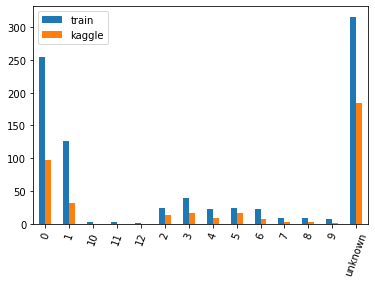

In [58]:
data_tools.plot_train_test_feats(X, X_kaggle, 'mode_localization_pos')

In [59]:
assert len(X.columns) - len(set(X.columns)) == 0

# Saving output

In [60]:
X.to_pickle(f"{out_fpath}X.pkl")
y.to_pickle(f"{out_fpath}y.pkl")

In [61]:
X_kaggle.to_pickle(f"{out_fpath}X_kaggle.pkl")

## For One-Hot Encoding
* need to concatenate the kaggle dataframe first, since not all categories are present in both training and kaggle data

In [62]:
# First concat X and competition data
combined = pd.concat((X, X_kaggle), axis=0)
combined.shape

(1243, 610)

In [63]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1243 entries, 0 to 380
Columns: 610 entries, 1 to nbr_corr_skew_3
dtypes: category(197), float64(135), int64(27), object(251)
memory usage: 4.2+ MB


Note that some datatypes have been altered. Let's coerce them back to the correct ones.

In [64]:
dtypes_dict = X.dtypes.astype(str).to_dict()

In [65]:
combined = combined.astype(dtypes_dict)
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1243 entries, 0 to 380
Columns: 610 entries, 1 to nbr_corr_skew_3
dtypes: category(450), float64(135), int64(25)
memory usage: 2.2 MB


In [66]:
# One-hot encode
categoricals = combined.select_dtypes(include=['category']).columns
combined_enc = pd.get_dummies(data=combined, columns=categoricals, drop_first=False)
combined_enc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1243 entries, 0 to 380
Columns: 2112 entries, 445 to ppi_min_corr_2944
dtypes: float64(135), int64(25), uint8(1952)
memory usage: 3.8 MB


Awesome! Let's split it back up into X_enc, X_kaggle_enc.

In [67]:
X_enc = combined_enc.iloc[:X.shape[0]]
X_enc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 862 entries, 0 to 861
Columns: 2112 entries, 445 to ppi_min_corr_2944
dtypes: float64(135), int64(25), uint8(1952)
memory usage: 2.7 MB


In [68]:
X_kaggle_enc = combined_enc.iloc[X.shape[0]:]
X_kaggle_enc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 381 entries, 0 to 380
Columns: 2112 entries, 445 to ppi_min_corr_2944
dtypes: float64(135), int64(25), uint8(1952)
memory usage: 1.2 MB


# Saving output (one-hot encoded)

In [69]:
X_enc.to_pickle(f"{out_fpath}X_enc.pkl")

In [70]:
X_kaggle_enc.to_pickle(f"{out_fpath}X_kaggle_enc.pkl")